In [1]:
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

COCO location: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset
Loading test Images form: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset/images/test2014
Loading test Annotarions form: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset/annotations/image_info_test2014.json
Vocabulary successfully loaded from vocab.pkl file!


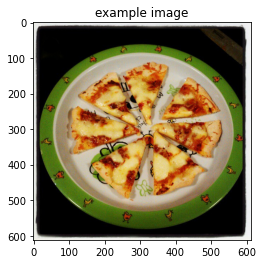

Image size:  torch.Size([1, 3, 224, 224])


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

print("Image size: ", image.shape )

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = 'encoder-500.pkl'
decoder_file = 'decoder-500.pkl'

embed_size = 1024
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers=3, drop=0.5)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (embed): Embedding(9955, 1024)
  (lstm): LSTM(1024, 512, num_layers=3, batch_first=True, dropout=0.5)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=9955, bias=True)
)

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 821, 13, 109, 21, 3, 3124, 6, 3, 2603, 18, 1]


In [6]:
def clean_sentence(output):
    parts = [data_loader.dataset.vocab.idx2word[i] for i in output][1:-1]
    return parts

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: ['a', 'plate', 'with', 'a', 'sandwich', 'and', 'a', 'cup', 'of', 'coffee', '.']


AssertionError: Sentence needs to be a Python string!

In [7]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

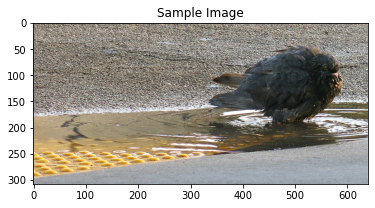

['a', 'bird', 'is', 'sitting', 'on', 'a', 'rock', 'in', 'the', 'water', '.']


In [8]:
get_prediction()

## Infarence JIT

In [9]:
def init_hidden(batch_size):
    return (torch.zeros(3, batch_size, hidden_size, device = device),
            torch.zeros(3, batch_size, hidden_size, device = device))

In [10]:
encoder_jit = torch.jit.load('encoder.pt', map_location=device)
decoder_jit = torch.jit.load('decoder.pt', map_location=device)

In [11]:
def sample(features, max_len=20):

    word_list = list()
    word_len = 0
    hidden = init_hidden(features.shape[0])

    with torch.no_grad():
        while word_len < max_len:
            out, features, hidden = decoder_jit(features, hidden)
            word_list.append(out.item())
            word_len += 1
            if out.item() == 1:
                break

    return word_list

In [12]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image)

In [13]:
sample(features=features.unsqueeze(1))

[0, 3, 821, 13, 109, 21, 3, 3124, 6, 3, 2603, 18, 1]

In [14]:
def get_prediction_T(orig_image, image):
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder_jit(image).unsqueeze(1)
    output = sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [15]:
def get_prediction(orig_image, image):
    
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [16]:
orig_image, image = next(iter(data_loader))

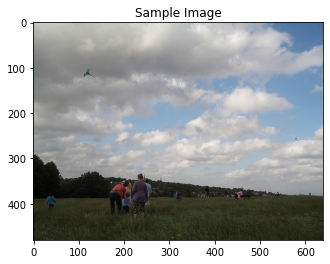

['a', 'group', 'of', 'people', 'standing', 'on', 'top', 'of', 'a', 'lush', 'green', 'field', '.']


In [17]:
get_prediction_T(orig_image, image)

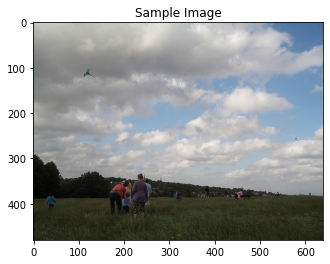

['a', 'group', 'of', 'people', 'standing', 'on', 'top', 'of', 'a', 'lush', 'green', 'field', '.']


In [18]:
get_prediction(orig_image, image)

## Evaluation Matrics

In [19]:
batch_size = 1
vocab_threshold = 5
vocab_from_file = True

transform_test = transforms.Compose([transforms.Resize(224),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),
                                                          (0.229, 0.224, 0.225))])
val_data_loader = get_loader(transform=transform_test,
                         mode='val_e',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

COCO location: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset
Loading val_e Images form: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset/images/val2014
Loading val_e Annotarions form: /home/jupyter/Caption-AI/ImageCaptioning/COCODataset/annotations/captions_val2014.json
Vocabulary successfully loaded from vocab.pkl file!
loading annotations into memory...


  0%|          | 0/202654 [00:00<?, ?it/s]

Done (t=0.29s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 202654/202654 [00:20<00:00, 9836.46it/s] 


In [20]:
def get_prediction_jit(image):
    image = image.to(device)
    features = encoder_jit(image).unsqueeze(1)
    output = sample(features)    
    sentence = clean_sentence(output)
    return sentence

In [21]:
def get_prediction(image):
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    return sentence

In [33]:
def get_caption(captions):
    cap_new =[]
    for cap in captions:
        _c = [i[0] for i in cap]
        cap_new.append(_c)
    return cap_new

In [23]:
import torch.utils.data as data
def get_data():
    indices = val_data_loader.dataset.get_train_indices()
    new_sampler_v = data.sampler.SubsetRandomSampler(indices=indices)
    val_data_loader.batch_sampler.sampler = new_sampler_v
            
    return next(iter(val_data_loader))

In [24]:
image, caption = get_data()

In [25]:
get_prediction_jit(image)

['a', 'truck', 'is', 'parked', 'in', 'a', 'parking', 'lot', '.']

In [34]:
get_caption(caption)

[['a',
  'loaded',
  'pickup',
  'and',
  'travel',
  'vehicle',
  'on',
  'the',
  'highway',
  '.'],
 ['a',
  'pick',
  'up',
  'truck',
  'with',
  'a',
  'golf',
  'cart',
  'loaded',
  'on',
  'the',
  'back'],
 ['a',
  'truck',
  'carrying',
  'a',
  'golf',
  'cart',
  'follows',
  'behind',
  'a',
  'motor',
  'home',
  '.'],
 ['a', 'truck', 'and', 'car', 'on', 'the', 'road'],
 ['a', 'pick', 'up', 'truck', 'follows', 'closely', 'behind', 'a', 'bus']]

### BLEU score

In [36]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [40]:
def avg_bleu(size = 100):
    blue = 0.0
    for _ in range(size):
        image, caption = get_data()

        chencherry = SmoothingFunction()
        blue += sentence_bleu(get_caption(caption), get_prediction_jit(image), smoothing_function=chencherry.method1)
    
    return blue / size

In [42]:
avg_bleu(size=500)

0.18974343412509365